In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# We load the dataset
df = pd.read_csv('Merged_Gold_dataset.csv')

df.head()

,Unnamed: 0,Date,Close,High,Low,Open,Volume,RSI,SMA10,SMA20,CPIAUCSL,CIVPART,GDP,GEPUCURRENT,PPIACO,UNRATE,CLI,GDP_Reference
0,0,2005-03-28,425.899994,425.899994,425.899994,425.899994,0,33.386323,434.190002,435.730000,193.1,65.9,12767.286,54.055710,153.7,5.2,100.3446,100.4980
1,1,2005-03-29,426.000000,426.000000,426.000000,426.000000,0,33.629056,432.680002,435.205000,193.1,65.9,12767.286,54.055710,153.7,5.2,100.3446,100.4980
2,2,2005-03-31,428.700012,428.700012,428.700012,428.700012,3051,39.987248,431.460004,434.995001,193.1,65.9,12767.286,54.055710,153.7,5.2,100.3446,100.4980
3,3,2005-04-01,425.899994,428.500000,424.500000,428.299988,552,36.122564,429.680002,434.650002,193.7,66.1,12922.656,68.682759,155.0,5.2,100.2931,100.5254
4,4,2005-04-04,423.899994,426.299988,422.700012,426.000000,486,33.622901,428.200000,434.350002,193.7,66.1,12922.656,68.682759,155.0,5.2,100.2931,100.5254


In [2]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

In [3]:
df['Close_SMA10_diff'] = df['Close'] - df['SMA10']
df['Close_SMA20_diff'] = df['Close'] - df['SMA20']
df['RSI_50_diff'] = df['RSI'] - 50
df['High_Low_diff'] = df['High'] - df['Low']
df['Open_Close_diff'] = df['Open'] - df['Close']

df['Close_lag1'] = df['Close'].shift(1)

# We clean the missing values
df = df.dropna().reset_index(drop=True)

# Define the prediction target: Close price of the next day
df['Close_t+1'] = df['Close'].shift(-1)
df = df.dropna(subset=['Close_t+1']).reset_index(drop=True)

# So, I selected the 3 features that have an impact on the gold price
feature_cols = ['Close', 'Low', 'High']


In [4]:
# I split the train and test, train is on 2018 to 2022, test on 2023
X = df[feature_cols]
y = df['Close_t+1']

X_train = X.iloc[0:3756]
y_train = y.iloc[0:3756]
X_test = X.iloc[3756:]
y_test = y.iloc[3756:]


In [5]:
# I train my RF model with RandomSearch
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [6]:
# I evaluate the model
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Best parameters found:", random_search.best_params_)
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"mAPE: {mape:.2f}%")

Best parameters found: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
RMSE: 327.5586
R² Score: -0.2104
mAPE: 7.77%


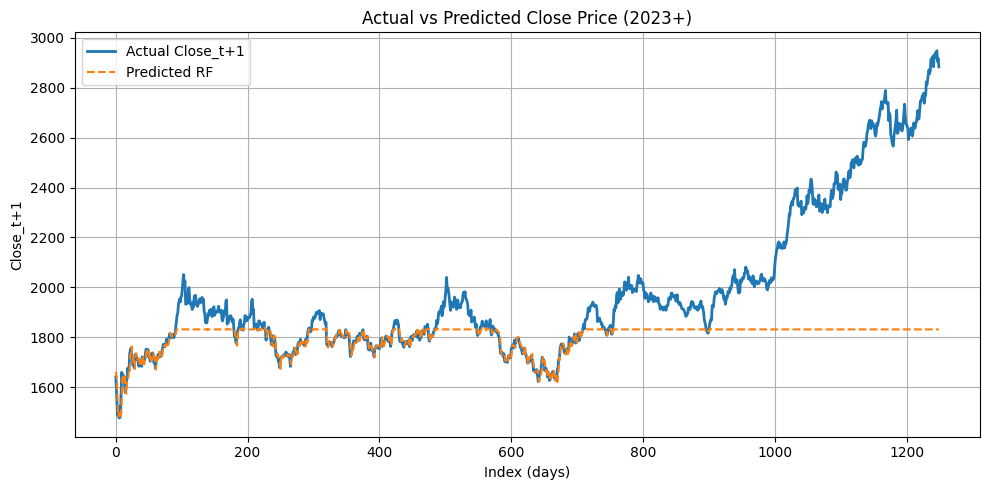

In [7]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Close_t+1', linewidth=2)
plt.plot(y_pred, label='Predicted RF', linestyle='--')
plt.title("Actual vs Predicted Close Price (2023+)")
plt.xlabel("Index (days)")
plt.ylabel("Close_t+1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-64-c4a30fc390d0>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette='viridis')


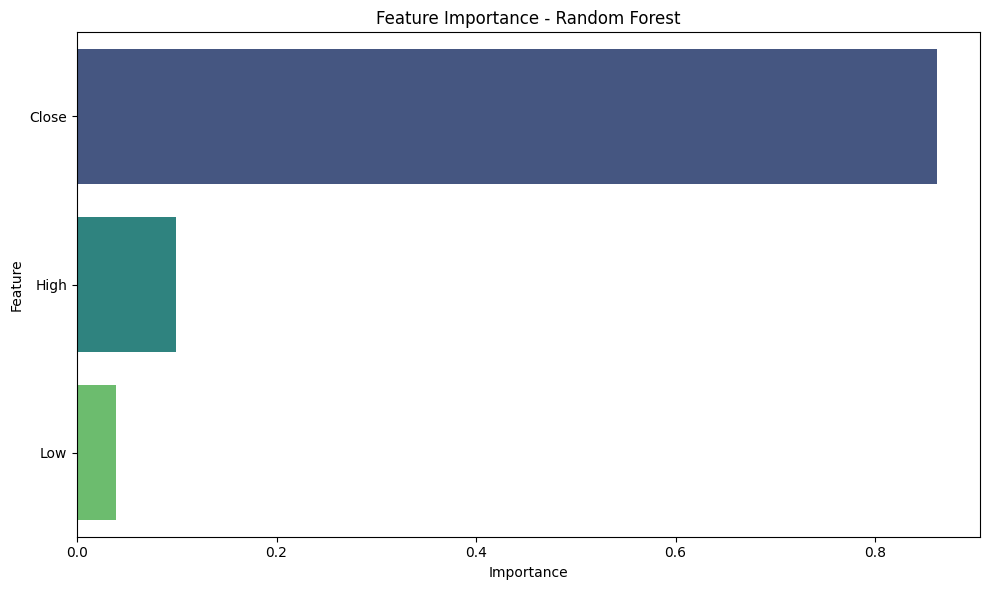

In [ ]:
# Plot feature importance
importances = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

------------------------------------------------------------
# Feature Selection Justification

To select the most relevant features for my Random Forest model, I first trained the model on all available variables in the dataset. Then I used the moded built-in feature importance scores to assess which features contributed the most to predictions.

The feature importance plot clearly showed that only three variables Close, Low, and High had significant impact on the model performance, while others contributed little to nothing.

So, I simplified my model by keeping only the three features.

You can execute the code down here to see

<ipython-input-63-c9d329e0366f>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices[:20]], y=features[indices[:20]], palette='viridis')


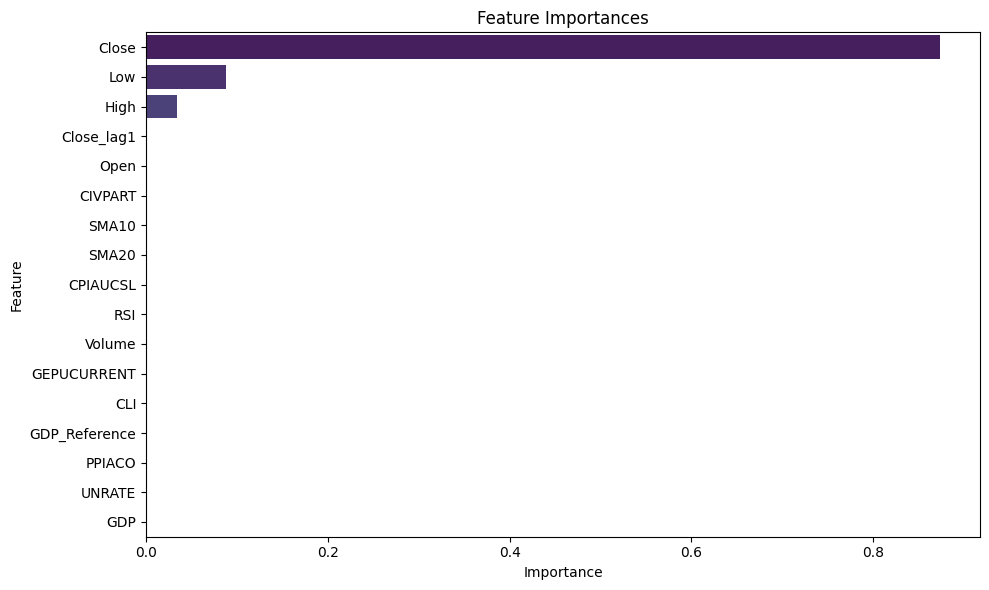

In [ ]:

df = pd.read_csv('Merged_Gold_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

df['Close_t+1'] = df['Close'].shift(-1)

df['Close_lag1'] = df['Close'].shift(1)

df = df.dropna().reset_index(drop=True)

feature_cols = [col for col in df.columns if col not in ['Date', 'Close_t+1']]

train_df = df[df['Date'] < '2023-01-01']
test_df = df[df['Date'] >= '2023-01-01']

X_train = train_df[feature_cols]
y_train = train_df['Close_t+1']
X_test = test_df[feature_cols]
y_test = test_df['Close_t+1']

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices[:20]], y=features[indices[:20]], palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()